## No segmentation - simple OCR all text in the image and check according to the Ukrainian plate format

In [1]:
# Uploaded images
images = [
    "AE1455KH_f.jpg",
    # "AE1455KH_a.jpg",
    # "AE1455KH_0.jpg",
    "AE1455KH_2.jpg",
    # "AE1455KH_b.jpg",
    # "AE1455KH_c.jpg",
    "KA7777XK.jpg",
    "KA7777AC.jpg",
    "KA3792KK.jpg",
    "AM3808CO.jpg",
    "BA2887EP.jpg",
    "AA6418XA.jpg",
    "BE0394EE.jpg",
    "AI3196OE.jpg",
    "BA5486HE.jpg",
    "DI5646IA.jpg",
    "KE3372AI.jpg",
    "AP3319CH.jpg",
    "KA5794BT.jpg",
    "BM7462BI.jpg",
    "BA9475HA.jpg",
    "AE3322BX.jpg",
    "BK9358HH.jpg",
    "BM0485CM.jpg",
    "AX7420OB.jpg",
    "AP9097HT.jpg",
    "AX8902EI.jpg",
    "AB7320KO.jpg",
    "AX0787CO.jpg",
    "BM8780EC.jpg",
    "AB6924KK.jpg",
    "AE6638KK.jpg",
    "KE1689AE.jpg",
    "AA1213KI.jpg",
    "BA9635HA.jpg",
    "KE6862AE.jpg",
    "AI8988IP.jpg",
    "BI9426HP.jpg",
    "AE0205XB.jpg",
    "EK7274.jpg",
    "AX2807OC.jpg",
    "AE8927TX.jpg",
    "CE7151EK.jpg",
    "AA3003OB.jpg",
    "BI3373EA.jpg",
    "KA1440EC.jpg",
    # "KA7777CA.jpg",
    "KA8781IO.jpg",
    "AB3747BC.jpeg",
    "AO1467BH.jpeg",
    "AA8168YA.jpg",
    "AE1455KH_3.jpg",
    "AE1455KH_4.jpg",
    "AE1455KH.jpg",
    "KA3713EX.jpg",
    "KA2014EX.jpg",
    "AA1488CH.jpg",
    "AA1870XA.jpg",
    "KA6003EK.jpg",
    "UVVI8I.jpg",
    "BUBO4KA.jpg",
    "AI2866YA.jpg",
    # "KA1088IO.jpg",
    "AH0576OC.jpg",
    "KA2803IT.jpg",
    "PYTHON.jpg",
    "PYTHON_2.jpg",
    "AE3591IT.jpg",
    "A00001A.jpg",
    # "AE7094HC.jpg",
    "AR024MI.jpg",
    "HH0001OO.jpg",
    # "KE3198AE.jpeg",
    "SN66XMZ.jpg",
    "BT5390BM.jpg",
    "KE7777HT.jpg",
    "AA9030PO.jpg",
    "KA2443II.jpg",
    "KA7975II.jpg",
    "NOT4YOU.jpg",
    "X7X.jpg",
    "DP0000SS_3.jpg",
    "AA3973ZA.jpg",
    "KA2891EO.jpg",
    "KA1730HK.jpg",
    "AE1455KH_e.jpg",
    "AE1455KH_d.jpg",
    "KA1596AO.jpg",
    "AA1716PP.jpg",
    "AI7013HK.jpg",
    "AE3591IT_2.jpg",
    "AE3591IT_3.jpg",
    "AX3020KK.jpg",
    "FART.jpg",
]

In [2]:
# # запускати один раз, потім можна закрити коментами
# !python.exe -m pip install --upgrade pip
# !pip3 install paddlepaddle
# !pip3 install paddleocr

In [3]:
# imports
import cv2
import os
import re
import matplotlib.pyplot as plt
import numpy as np
from paddleocr import PaddleOCR

In [4]:
# Initialize PaddleOCR with English language model
ocr = PaddleOCR(
    use_angle_cls=True,
    lang="en",
    use_gpu=True,
    total_process_num=os.cpu_count() * 2 - 1,
    show_log=False,
)

plate_cascade = cv2.CascadeClassifier("../models/haarcascade_ua_license_plate.xml")

In [5]:
# not_number - correction
NOT_NUMBER = [
                "UA",
                "JA",
                "11",
                "10",
                "16",
                "RXETD",
                "21",
                "22",
                "I",
                "Q",
                "X",
                "II",
                'AS',
                "F923",
                "SS00",
                "RANGEROVER",
                "RANGE",
                "ROVER",
                "KIA",
            ]

     Функції обробки тексту, що розпізнано 

In [6]:
# позиційна обробка ["1", "0", "7", '8'] <-> ["I", "O", "Z", 'B']
def correction_ua_number(text):
    # if len(text) == 8:
    text_list = list(text)

    for i in [0, 1, 6, 7]:
        text_list[i] = (
            text_list[i]
            .replace("1", "I")
            .replace("i", "I")
            .replace("|", "I")
            .replace("0", "O")
            .replace("7", "Z")
            .replace("8", "B")
            .replace("5", "B")
        )

    for i in [2, 3, 4, 5]:
        text_list[i] = (
            text_list[i]
            .replace("I", "1")
            .replace("|", "1")
            .replace("O", "0")
            .replace("Z", "7")
            .replace("B", "8")
        )

    text = "".join(text_list)
    return text


# Validate Ukrainian plate format
def validate_ukraine_plate(text):
    pattern = r"^[A-Z]{2}\d{4}[A-Z]{2}$"
    return bool(re.match(pattern, text))

In [7]:
# обробка тексту, що розпізнано на номері
def processing_number_text(result):
    text_up = ""

    for line in result:

        for word in line:

            text = word[1][0].strip().replace("\n", "").replace(" ", "")

            if len(text) == 8:
                text = correction_ua_number(text)

            if text in NOT_NUMBER:
                continue

            # для американських номерів (в 2 ряди)
            if re.match(r"^[A-Z]{4}$", text):
                text_up = text
            elif re.match(r"^\d{4}$", text) and re.match(r"^[A-Z]{4}$", text_up):
                text = text_up[:2] + text + text_up[2:]
                text_up = ""

            # милиця - щоб повертати номери, які визначено як українські
            output_text = text 

            if re.match(r"^[A-Z0-9]+$", text):
                if validate_ukraine_plate(text):
                    print(f"Detected License Plate: \033[33m{text}\033[0m") # Yellow
                else:
                    print(f" Invalid License Plate: \033[31m{text}\033[0m") # Red
        # print(f"{output_text = }")
    return output_text

In [8]:
# Extract license plate text using PaddleOCR
def extract_license_plate_text(image_path):

    # OCR debug - сірим кольором
    print("\033[90m", end="")
    result = ocr.ocr(image_path)
    print("\033[0m", end="")

    return processing_number_text(result)

In [9]:
# display image function
def display(img_, title=""):
    """
    функція виводу зображень з заголовком
    """
    img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    ax.imshow(img)
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.show()

In [10]:
# display result function
def display_result(
    img_,
    title="",
    recognized_text="",
    # recognized_text="",
    font_scale=2,
    font_thickness=3,
):

    BOX_COLOR = (255, 255, 255)
    # Copy the image to avoid modifying the original one
    img = img_.copy()
    # Font settings for OpenCV
    font = cv2.FONT_HERSHEY_SIMPLEX

    # Position for the ocr-text near the top of the image
    text_position = (50, 100)  # Starting position for the text

    # Calculate the size of the text box
    (text_width, text_height), baseline = cv2.getTextSize(
        recognized_text, font, font_scale, font_thickness
    )

    # Calculate the coordinates for the white rectangle
    box_coords = (
        (text_position[0] - 10, text_position[1] + baseline - text_height - 30),
        (text_position[0] + text_width + 10, text_position[1] + baseline - 10),
    )

    # Draw the 'BOX_COLOR' rectangle
    cv2.rectangle(img, box_coords[0], box_coords[1], BOX_COLOR, cv2.FILLED)

    # Add recognized text to the image
    img = cv2.putText(
        img,
        recognized_text,
        text_position,
        font,
        font_scale,
        (255, 0, 0),
        font_thickness,
        cv2.LINE_AA,
    )

    display(img, title=title)


 ================================================================================  1 
      Processing image: AE1455KH
Detected License Plate: AE1455KH


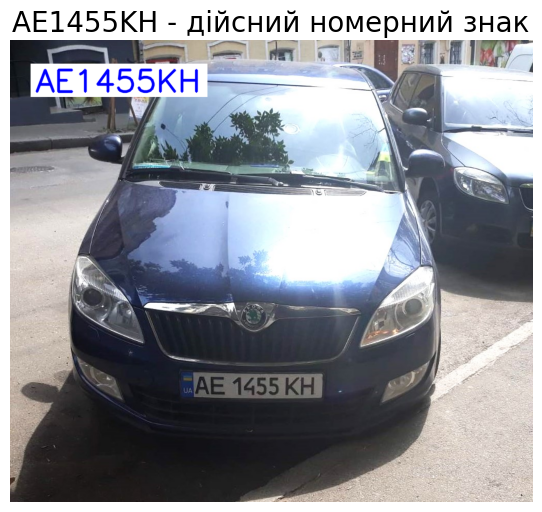

Error: File  AE1455KH_2.jpg  could not be loaded


In [11]:
# Process each image and extract license plate text
num_photo = 0
for image in images:

    clear_number = image.split(".")[0].split("_")[0]
    image_path = cv2.imread("../images/" + image)

    # Check if the image is loaded correctly
    if image_path is None:
        print(
            f"\033[31mError: \033[0mFile \033[37m {image} \033[0m could not be loaded"
        )
        break

    num_photo += 1
    print("\n", 80 * "=", "\033[90m", num_photo, "\033[0m")
    print(f"      Processing image: \033[33m{clear_number}\033[0m")

    plate_number_ocr = extract_license_plate_text(image_path) # ocr

    display_result(
        image_path,
        title=clear_number + " - дійсний номерний знак",
        recognized_text=plate_number_ocr,
    )